In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import math
import torch
import os
import helper
from google.colab import drive
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch import optim
import gensim
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec


import coutils
from coutils import fix_random_seed, rel_error, compute_numeric_gradient, \
                    tensor_to_image, decode_captions
import matplotlib.pyplot as plt
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-8zdeq2my
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-8zdeq2my
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10307 sha256=0bec1976b771560bba9250c2e16035af190c7115d14b6ce8cd68b0b5e29b0e7c
  Stored in directory: /tmp/pip-ephem-wheel-cache-peyg7eyr/wheels/df/48/31/42e6165d14813d97f1555dcf2a92742f78e9d0c90811ef7325
Successfully built Colab-Utils


In [ ]:
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Read in a file from drive, parse into list
def load_data(path):

    input_file = os.path.join(path)
    with open(input_file, "r", encoding='utf-8') as f:
        data = f.read().strip()

    return data.split('\n')

In [ ]:
#define a language class to store indexes and vocabulary
class lang():
    def __init__(self, name, data):
      self.name = name
      self.data = data
      self.word2index = {}
      self.wordcount = {}
      self.end = 1
      self.start = 0
      self.index2word = {0:"<START>", 1:"<END>"}
      self.words = 2

    def insertWord(self, word):
      if word not in self.word2index:
        self.word2index[word] = self.words
        self.wordcount[word] = 1
        self.index2word[self.words] = word
        self.words +=1
      else:
        self.wordcount[word] += 1

    def insertSentence(self, input):
      for word in input.split(' '):
          self.insertWord(word)


*************************
Load pretrained embeddings if necessary


In [ ]:
def loadPretrainedEmbeddings(gloveFile):
  input_file = os.path.join(gloveFile)
  glove_file = datapath(input_file)

  tmp_file = get_tmpfile("test_word2vec.txt")
  _ = glove2word2vec(glove_file, tmp_file)

  weights = torch.FloatTensor(KeyedVectors.load_word2vec_format(tmp_file).vectors)
  embedding = nn.Embedding.from_pretrained(weights)

  return embedding

In [ ]:
class encode(nn.Module):
  def __init__(self, inputSize,hiddenSize, num_layers = 1, bidirectional=False):
    super(encode,self).__init__()
    #print(hiddenSize)
    self.hiddenSize = hiddenSize
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.embedding = nn.Embedding(inputSize,self.hiddenSize)
    self.GRU = nn.GRU(inputSize,hiddenSize, bidirectional = self.bidirectional)

  def init(self):
    if self.bidirectional:
      return torch.zeros(2,1,self.hiddenSize, device=device)
    else:
      return torch.zeros(self.num_layers,1,self.hiddenSize, device=device)

  def forward(self, input, hidden):
    embedding = self.embedding(input).view(1,1,-1).to(device)
    #embedding = self.pretrained(input).view(1,1,-1)
   #print("========test: ",embedding.shape, " actual: ", hidden.shape)
    #print("========test: ",embedding2[0], " actual: ", embedding[0])

    output, hidden = self.GRU(embedding, hidden)
    return output, hidden
    

In [ ]:
class decode(nn.Module):
  def __init__(self, hiddenSize, outSize, d_out = 0.18, length = 100, num_layers = 1, bidirectional=False):
    super(decode,self).__init__()
    
    #properties
    self.num_layers = num_layers
    self.outputSize = outSize
    self.hiddenSize = hiddenSize
    self.d_out = d_out
    self.length = length
    self.bidirectional = bidirectional

    #functions
    #self.pretrained = loadPretrainedEmbeddings('/content/drive/MyDrive/data/glove.6B.50d.txt')
    self.drop = nn.Dropout(self.d_out)
    self.embedding = nn.Embedding(outSize, hiddenSize)
    self.attention = nn.Linear(self.hiddenSize * 2, self.length)

    if self.bidirectional:
      self.combine = nn.Linear(self.hiddenSize   *3   , self.hiddenSize)
      self.outLayer = nn.Linear(hiddenSize  *2  ,outSize)
    else:
      self.combine = nn.Linear(self.hiddenSize   *2   , self.hiddenSize)
      self.outLayer = nn.Linear(hiddenSize,outSize)

    self.GRU = nn.GRU(hiddenSize,hiddenSize,num_layers=self.num_layers, bidirectional = self.bidirectional)
    self.GRU2 = nn.GRU(hiddenSize*2,hiddenSize,num_layers=self.num_layers, bidirectional = self.bidirectional)
    self.activation = nn.LogSoftmax(dim=1)
  
  def init(self):
    if self.bidirectional:
      return torch.zeros(2,1,self.hiddenSize, device)
    else:
      return torch.zeros(self.num_layers,1,self.hiddenSize, device)
      
  #Architecture:
  # Embed-|
  #       dropout - Linear/FC - softmax - apply attention
  #       - leaky relu - (bidir) gru layer 1 - dropout - (bidir) gru layer 2 - softmax

  def forward(self, input, hidden, outs):
    #print("forward call")
    embedding = self.embedding(input).view(1,1,-1)
    #embedding = self.pretrained(inpu t).view(1,1,-1)

    embedding = self.drop(embedding)

    attn = self.attention(torch.cat((embedding[0],hidden[0]), 1))
    a_w = F.softmax(attn, dim=1)

    comb = torch.cat(( embedding[0], torch.matmul(a_w.unsqueeze(0), outs.unsqueeze(0))[0]), 1)
    comb = self.combine(comb).unsqueeze(0)

    relu = F.leaky_relu(comb)

    output, hidden = self.GRU(relu, hidden)
    #add secondary gru!
    output = self.drop(output)

    output, hidden = self.GRU2(output, hidden)

    sigresult = self.activation(self.outLayer(output[0]))

    return sigresult, hidden

In [ ]:
def train(inputT, outputT, enc, dec,encoptim, decoptim, goal, length=100):
  
  output_size = enc.hiddenSize*2 if enc.bidirectional else enc.hiddenSize

  hidden = enc.init()
  #print("hidden: ", hidden)
  encoptim.zero_grad()
  decoptim.zero_grad()

  outputs = torch.zeros(length, output_size, device=device)
  #print(outputs.size())

  loss = 0

  for i in range(inputT.size(0)):
    enc_out, enc_h = enc(inputT[i], hidden)
    outputs[i] = enc_out[0,0]
  
  dec_in = torch.tensor([[0]], device = device)

  for t in range(outputT.size(0)):
    dec_out, hidden = dec(dec_in, hidden, outputs)
    _, topi = dec_out.topk(1)
    dec_in = topi.squeeze().detach()

    loss += goal(dec_out, outputT[t])
    if dec_in == 1:
      break
  

  loss.backward()
  encoptim.step()
  decoptim.step()

  return loss.item()/outputT.size(0)

In [ ]:
def iterate(lang1, lang2, enc, dec, iters, print_freq = 1000, plot_freq = 100, lr = 0.01):
  total = 0

  encoptim = optim.Adagrad(enc.parameters(), lr = lr)
  decoptim = optim.Adagrad(dec.parameters(), lr = lr)

  #print(pairs)
  t_pairs = []

  for i in range(iters):
    selected_pair = random.choice(pairs)

    indinput =  [lang1.word2index[word] for word in selected_pair[0].split(' ')]
    indinput.append(lang1.end)

    indoutput =  [lang2.word2index[word] for word in selected_pair[1].split(' ')]
    indoutput.append(lang2.end)

    t_pairs.append((torch.tensor(indinput, **to_long_cuda).view(-1,1)\
                   ,torch.tensor(indoutput, **to_long_cuda).view(-1,1)))

  goal = nn.NLLLoss()
  data = []
  for iter in range(1,iters+1):
    t_pair = t_pairs[iter - 1]
    inputT = t_pair[0]
    outputT = t_pair[1]

    loss = train(inputT,outputT,enc,dec,encoptim,decoptim,goal)

    total += loss

    if iter % print_freq == 0:
      print_avg = total / print_freq
      data.append(print_avg)
      total = 0
      print('Iter: ', iter,' of ', iters,' loss: ', print_avg)
  return data

In [ ]:
def eval(lang1, lang2, enc, dec, sentence, length = 100):
  with torch.no_grad():
    output_size = enc.hiddenSize*2 if enc.bidirectional else enc.hiddenSize

    enc_h = enc.init()
    
    indinput =  [lang1.word2index[word] for word in sentence.split(' ')]
    indinput.append(lang1.end)

    inputT = torch.tensor(indinput, **to_long_cuda).view(-1,1)
    inputSize = inputT.size()[0]

    enc_outs = torch.zeros(length, output_size, device=device)

    for i in range(inputSize):
      enc_out, enc_h = enc(inputT[i], enc_h)
      enc_outs[i] += enc_out[0,0]

    dec_in = torch.tensor([[0]], device=device)

    decoded = []

    for t in range(length):
      dec_out, enc_h = dec(dec_in, enc_h, enc_outs)
      topv, topi = dec_out.data.topk(1)
      if topi.item() == 1:
        break
      else:
        decoded.append(lang2.index2word[topi.item()])
      dec_in = topi.squeeze().detach()

    return decoded

In [35]:
en = load_data('/content/drive/MyDrive/data/small_vocab_en.txt')
slang = load_data('/content/drive/MyDrive/data/inputforslang.txt')
print(en[0])
print(slang[0])
print('Dataset Loaded')

print('Parsing: ',len(en), ' input=> to => ', len(slang),' output')

if(len(en)!=len(slang)):
  print('Must have same number of sentences')

pairs = list(zip(en,slang))
split = 80000
val_set = pairs[split:]
pairs = pairs[:split]

langin = lang("en",en)
langout = lang("slang",slang)

for pair in pairs:
  langin.insertSentence(pair[0])
  langout.insertSentence(pair[1])

print("loaded: ", langin.words,' ',"lang1", " input words and ", langout.words, " output words.")
print("using: ", len(pairs), " sentences for training and: ", len(val_set), " sentences for validation")

new jersey is sometimes quiet during autumn , and it is snowy in april .
jersey is kinda quiet in fall , and its snowy in april .
Dataset Loaded
Parsing:  137860  input=> to =>  137860  output
loaded:  230   lang1  input words and  239  output words.
using:  80000  sentences for training and:  57860  sentences for validation


In [ ]:
# the number of 'features' being used in the hidden state
h_size = langin.words

english = langin
slang = langout

print("using: ", device)
encoder = encode(english.words, h_size, bidirectional=True).to(device)
decoder = decode(h_size, slang.words,bidirectional=True).to(device)

resdata = iterate(english, slang, encoder,decoder,20000,1000,1)

using:  cuda
Iter:  1000  of  20000  loss:  2.435603874690412
Iter:  2000  of  20000  loss:  1.8504891893445568
Iter:  3000  of  20000  loss:  1.5181393439809527
Iter:  4000  of  20000  loss:  1.306614156644914
Iter:  5000  of  20000  loss:  1.2205723077168265
Iter:  6000  of  20000  loss:  1.0476820093060801
Iter:  7000  of  20000  loss:  0.972661385337317
Iter:  8000  of  20000  loss:  0.9295060351670623
Iter:  9000  of  20000  loss:  0.7873996409190259
Iter:  10000  of  20000  loss:  0.7643979222524061
Iter:  11000  of  20000  loss:  0.7304406153097206
Iter:  12000  of  20000  loss:  0.6747372144452412
Iter:  13000  of  20000  loss:  0.6733688610115789
Iter:  14000  of  20000  loss:  0.6458379632683504
Iter:  15000  of  20000  loss:  0.6187025436211473
Iter:  16000  of  20000  loss:  0.6322219570296245
Iter:  17000  of  20000  loss:  0.5465773853722818
Iter:  18000  of  20000  loss:  0.5492477588190864
Iter:  19000  of  20000  loss:  0.5182513218215294
Iter:  20000  of  20000  loss:

In [ ]:
def getscores(lang1, lang2, enc, dec, n=10):

  bleu = []
  for i in range(n):
    pair = val_set[i]
    output_words = eval(lang1, lang2, enc, dec, pair[0])

    print("expected: ", pair[1], " got: ", ' '.join(output_words))

    bleu.append((pair[1].split(' '),output_words))
  return bleu

In [ ]:
output = getscores(english, slang, encoder, decoder,7860)
print("output is: ", len(output))

Streaming output truncated to the last 5000 lines.
expected:  the us aint dope asf in aug , but it aint slayin in nov .  got:  the us aint dope in in in , but it aint slayin in nov .
expected:  he dont fw peaches , yellow glizzies , and pears .  got:  she dont fw peaches , yellow glizzies , and apples .
expected:  she fw peaches , mangoes , and grapes .  got:  she fw peaches , mangoes , and lemons .
expected:  that monkey we dont fw animal .  got:  she monkey is dont fw fruit fruit .
expected:  the grapefruits my fav fruit , but the yellow glizzy is ur fav .  got:  the grapefruits her fav fruit , but the yellow glizzy is dont least fav .
expected:  he drive that old red automobile .  got:  she drive that old red automobile .
expected:  we dont fw lemons , oranges , and strawberries .  got:  she dont fw lemons , oranges , and lemons .
expected:  paris is usually busy in june , but it aint slayin in dec .  got:  china is usually busy in june , but it aint slayin in dec .
expected:  their

==============Now Calculate BLEU Score=======================


In [ ]:
import nltk
def calculateBLEU(choice):
  hypothesis = choice[0]
  reference = choice[1]
  #there may be several references
  BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
  return BLEUscore

def calculateAverageBLEU(outputs):
  scores = []
  for i in range(len(outputs)):
    scores.append(calculateBLEU(outputs[i]))
  return sum(scores) / len(scores)

In [34]:

print("Average BLEU score for ",len(output), ": ",calculateAverageBLEU(output))

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

Average BLEU score for  7860 :  0.5102045512384102


20


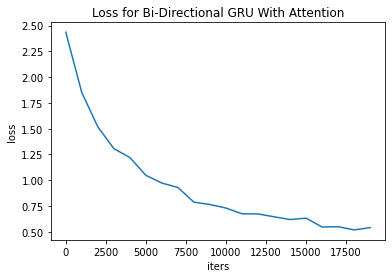

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
print(len(resdata))
x = np.arange(0,len(resdata)*1000,1000)
plt.plot(x,resdata)
plt.ylabel('loss')
plt.xlabel('iters')
plt.title('Loss for Bi-Directional GRU With Attention')
plt.show()